# Car Parking checker


Enric Ferrera González  
Miguel López Manzanares  
Joan Marc  

El objectiu del projecte de visió per computador es crear un programa que comprovi les plaçes d'aparcament d'un parking. Si están buides o plenes y en cas de que estiguin plenes, detectar la matrícula del coche, el color y si es pot la marca.  

Es realitzará de dues maneres, primer amb métodes clásics de la visió per computador y després amb métodes moderns com, per exemple, les xarxes neuronals. 

# Part clàsica

### 1. Dectectar línies
Per començar la part clàsica volem detectar les línies de les plaçes d'aparcament.

Per detectar les línies d'aparcament en una imatge d'un aparcament utilitzant mètodes clàssics de visió per computador, es poden seguir els següents passos:

1. **Conversió a escala de grisos:** Facilita el processament de la imatge.
2. **Filtrat de soroll:** S'utilitza un filtre com el Gaussian Blur per reduir el soroll.
3. **Detecció de vores:** S'aplica l'algoritme de Canny per detectar les vores de la imatge.
4. **Transformada de Hough:** Permet detectar línies rectes a la imatge, que corresponen a les línies d'aparcament.
5. **Dibuix de les línies detectades:** Es mostren les línies sobre la imatge original per visualitzar el resultat.

Aquests passos es poden implementar amb la llibreria OpenCV.

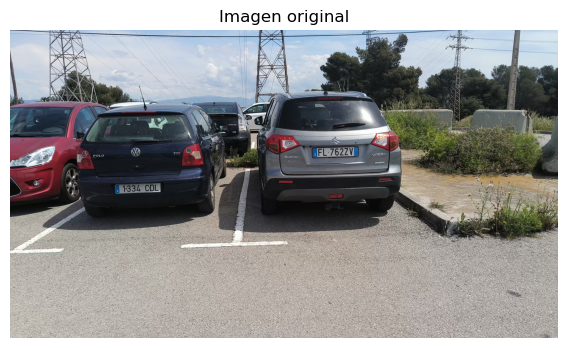

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(img, title="", cmap='gray'):
    plt.figure(figsize=(12, 4))
    if len(img.shape) == 2:  # grayscale
        plt.imshow(img, cmap=cmap)
    else:  # BGR to RGB for color images
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Cargar imagen
image = cv2.imread("frames/frame_0001.jpg")
original = image.copy()
show_image(image, "Imagen original")




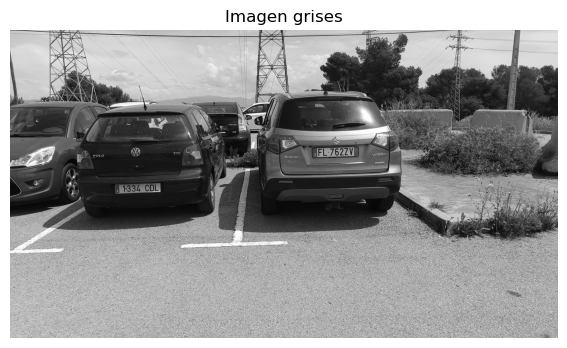

In [11]:
# Convertir a escala de grises
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
show_image(gray, "Imagen grises")

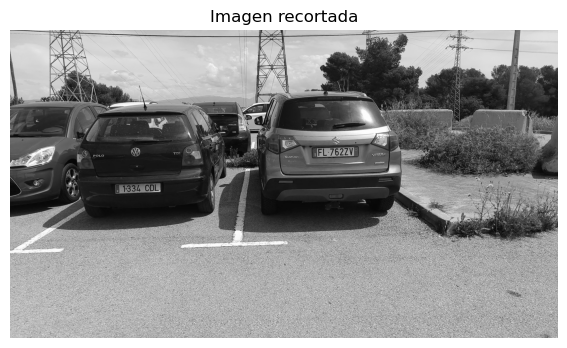

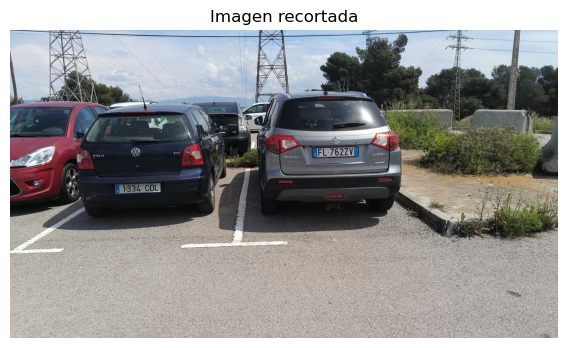

In [16]:
# Recortar si es necesario (ajustar offset si ya recortabas antes)
offset_y = 0
roi = gray[offset_y:]
roi_color = image[offset_y:]
show_image(roi, "Imagen recortada")
show_image(roi_color, "Imagen recortada")

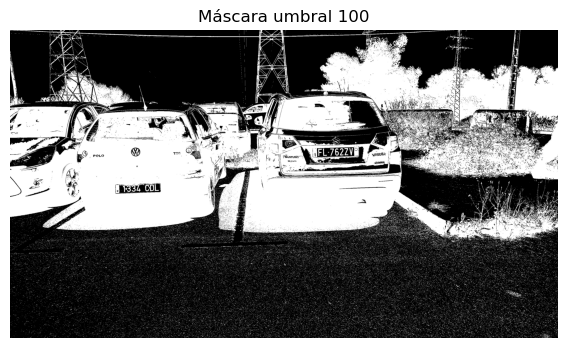

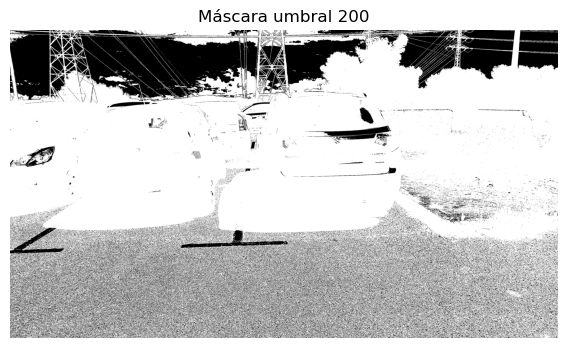

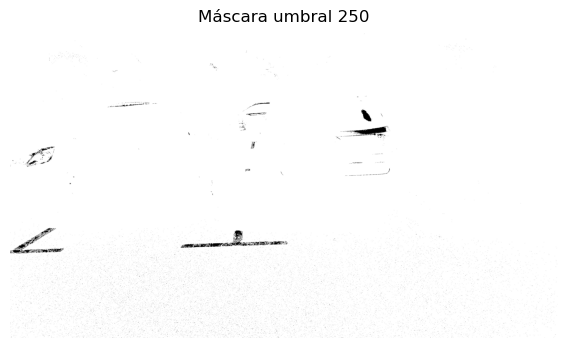

In [13]:
th1 = 100
th2 = 200
th3 = 250

# TODO. Apply the 3 thresholds 5 to the image
threshimtext1 = (roi < th1).astype(np.uint8) * 255
threshimtext2 = (roi < th2).astype(np.uint8) * 255
threshimtext3 = (roi < th3).astype(np.uint8) * 255

show_image(threshimtext1, "Máscara umbral 100")
show_image(threshimtext2, "Máscara umbral 200")
show_image(threshimtext3, "Máscara umbral 250")

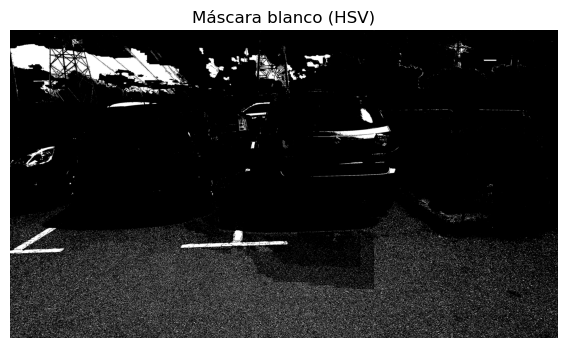

In [17]:
# --- Paso 1: Convertir a HSV y filtrar blancos ---
# H = Tono
# S = Saturación
# V = Valor (brillo)
hsv = cv2.cvtColor(roi_color, cv2.COLOR_BGR2HSV)
lower_white = np.array([0, 0, 220])
upper_white = np.array([180, 20, 255])
mask_white = cv2.inRange(hsv, lower_white, upper_white)
show_image(mask_white, "Máscara blanco (HSV)")

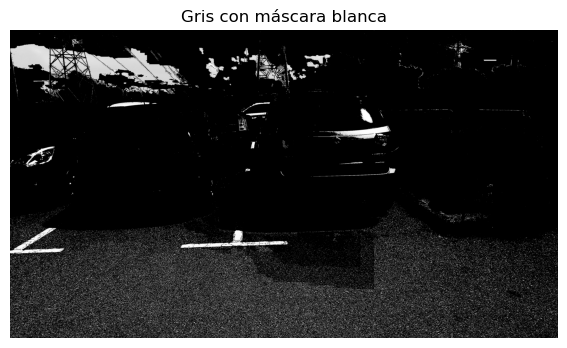

In [19]:
# --- Paso 2: Aplicar máscara a imagen en escala de grises ---
gray = cv2.cvtColor(roi_color, cv2.COLOR_BGR2GRAY)
gray_masked = cv2.bitwise_and(gray, gray, mask=mask_white)
show_image(gray_masked, "Gris con máscara blanca")

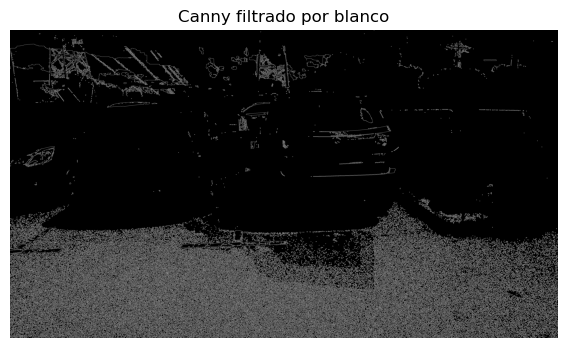

In [20]:
# --- Paso 3: Suavizado y Canny ---
blur = cv2.GaussianBlur(gray_masked, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)
show_image(edges, "Canny filtrado por blanco")

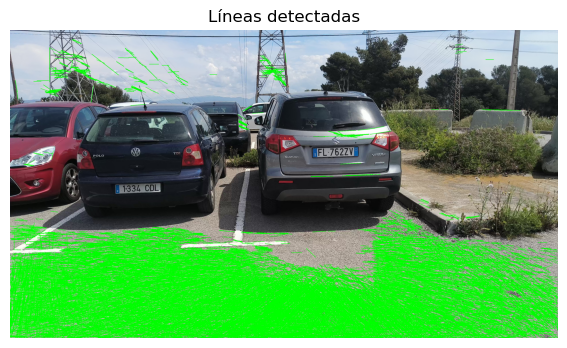

In [22]:
# --- Paso 4: Detección de líneas con Hough ---
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)
line_img = roi_color.copy()

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

show_image(line_img, "Líneas detectadas")


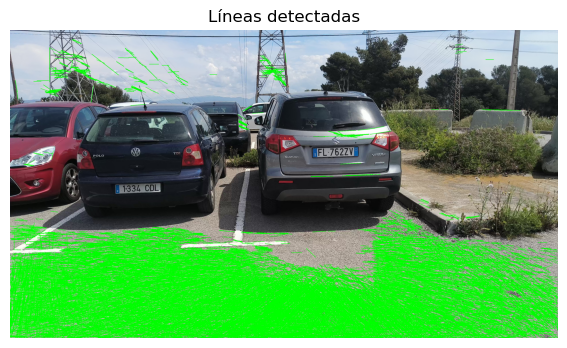

In [27]:
# --- Paso 4: Detección de líneas con Hough ---
new_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
# Filtrat per reduir soroll
gray_blur = cv2.GaussianBlur(new_gray, (5, 5), 0)
median_blur = cv2.medianBlur(new_gray, 5)

# Detectar contorns amb Canny
edges = cv2.Canny(median_blur, 100, 250)

# Transformada de Hough per detectar línies
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80, minLineLength=50, maxLineGap=30)

# Dibuixar només les línies amb angle gairebé horitzontal o vertical
lines_img = roi_color.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))
        if abs(angle) < 10 or abs(angle - 90) < 10 or abs(angle + 90) < 10:
            cv2.line(lines_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

show_image(line_img, "Líneas detectadas")
